In [1]:
import json
import os

import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [2]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

json_path = '../data/arxiv-metadata-oai-snapshot.json'
if not os.path.exists(json_path):
    raise FileNotFoundError(f"Please download the arXiv metadata from {json_path}")

load_existing = True
parquet_path = '../data/arxiv_metadata.parquet.gzip'


category_map_path = '../data/category_map.json'

with open(category_map_path, 'r') as f:
    category_map = json.load(f)

In [3]:
# load json into pandas dataframe in chunks and only keep the relevant columns
if load_existing and os.path.exists(parquet_path):
    print(f"Loading existing parquet file from {parquet_path}")
    data_df = pd.read_parquet(parquet_path, engine='pyarrow')
    display(data_df.head(2), data_df.tail(2))
    print(f"Loaded {len(data_df)} rows")
else:
    columns_to_keep = ['id', 'title', 'abstract', 'categories', 'update_date']
    dtypes = {'id': str, 'title': str, 'abstract': str, 'categories': str, 'update_date': str}
    chunksize = 100_000
    reader = pd.read_json(json_path, lines=True, chunksize=chunksize)

    data_to_keep = []
    for i, chunk in enumerate(reader):
        print(f"Processing chunk {i} - so far {len(data_to_keep) * chunksize} rows")
        data_to_keep.append(chunk[columns_to_keep].to_dict(orient='records'))
    data_to_keep = [item for sublist in data_to_keep for item in sublist]
    new_df = pd.DataFrame(data_to_keep).reset_index(drop=True)
    for col in columns_to_keep:
        new_df[col] = new_df[col].astype(dtypes[col])
    del data_to_keep

    display(new_df.head(2), new_df.tail(2))

    new_df.to_parquet(parquet_path, compression='gzip', engine='pyarrow')

Loading existing parquet file from ../data/arxiv_metadata.parquet.gzip


,id,title,abstract,categories,update_date
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,2008-11-26
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,2008-12-13


,id,title,abstract,categories,update_date
2477301,supr-con/9609003,Density of States and NMR Relaxation Rate in A...,We show that the density of states in an ani...,supr-con cond-mat.supr-con,2009-10-30
2477302,supr-con/9609004,Ginzburg Landau theory for d-wave pairing and ...,The Ginzburg Landau theory for d_{x^2-y^2}-w...,supr-con cond-mat.supr-con,2009-10-30


Loaded 2477303 rows


In [4]:
data_df['title_words'] = data_df['title'].apply(lambda x: len(x.split()))
data_df['abstract_words'] = data_df['abstract'].apply(lambda x: len(x.split()))
data_df['categories'] = data_df['categories'].apply(lambda x: x.split())
data_df['mapped_categories'] = data_df['categories'].apply(lambda x: [category_map[cat] if cat in category_map else "UNKNOWN" for cat in x])
data_df['amount_categories'] = data_df['categories'].apply(lambda x: len(x))
data_df['update_year'] = data_df['update_date'].apply(lambda x: int(x[:4]))
data_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,[hep-ph],2008-11-26,12,140,[High Energy Physics - Phenomenology],1,2008
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...","[math.CO, cs.CG]",2008-12-13,3,115,"[Combinatorics, Computational Geometry]",2,2008
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,[physics.gen-ph],2008-01-13,14,144,[General Physics],1,2008


In [42]:
# use mapped categories and build super categories
with open('../data/super_categories.json', 'r') as f:
    super_categories = json.load(f)
super_category_map = {cat: super_cat for super_cat, cats in super_categories.items() for cat in cats}

data_df['super_categories'] = data_df['mapped_categories'].apply(
        lambda x: [super_category_map[cat] if cat in super_category_map else f"UNKNOWN_{cat}" for cat in x]
    )
# take the super group with the most occurrences
data_df['super_category'] = data_df['super_categories'].apply(lambda x: max(set(x), key=x.count))
data_df['amount_super_categories'] = data_df['super_categories'].apply(lambda x: len(x))

In [49]:
print(f'Max number of words in title: {data_df["title_words"].max()}')
print(f'Max number of words in abstract: {data_df["abstract_words"].max()}')
print("-" * 50)
print(f'Min number of words in title: {data_df["title_words"].min()}')
print(f'Min number of words in abstract: {data_df["abstract_words"].min()}')
print("-" * 50)
print(f'Mean number of words in title: {data_df["title_words"].mean()}')
print(f'Mean number of words in abstract: {data_df["abstract_words"].mean()}')
print("-" * 50)
print(f'Median number of words in title: {data_df["title_words"].median()}')
print(f'Median number of words in abstract: {data_df["abstract_words"].median()}')

Max number of words in title: 61
Max number of words in abstract: 925
--------------------------------------------------
Min number of words in title: 1
Min number of words in abstract: 1
--------------------------------------------------
Mean number of words in title: 9.751281534798125
Mean number of words in abstract: 140.6586021168989
--------------------------------------------------
Median number of words in title: 9.0
Median number of words in abstract: 135.0


<Axes: xlabel='title_words', ylabel='Count'>

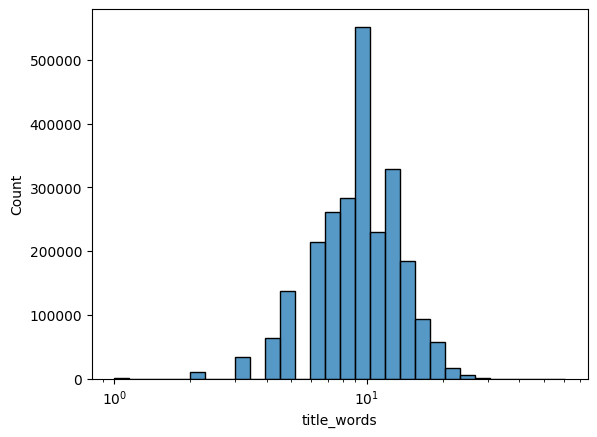

In [50]:
# histogram of number of words in titles and abstracts
sns.histplot(data_df['title_words'], bins=30, log_scale=True)

<Axes: xlabel='abstract_words', ylabel='Count'>

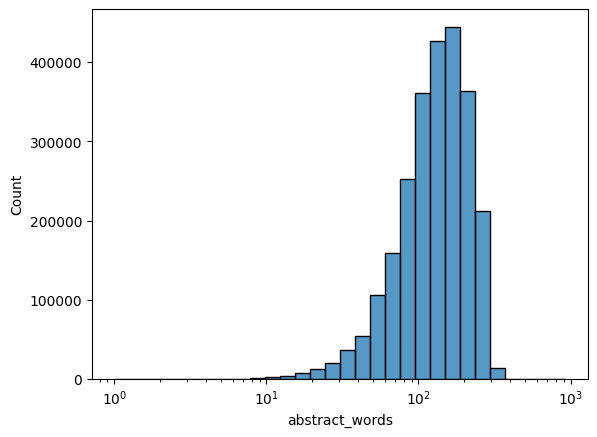

In [51]:
sns.histplot(data_df['abstract_words'], bins=30, log_scale=True)

[1] Physics: 759190
[2] Mathematics: 452843
[3] Artificial Intelligence: 379667
[4] Astrophysics and Cosmology: 295409
[5] Materials Science and Condensed Matter Physics: 211597
[6] Computer Science: 114251
[7] Data Science and Information Theory: 89123
[8] Engineering and Technology: 56256
[9] Social Sciences and Humanities: 32355
[10] Earth and Environmental Sciences: 24024
[11] Biological Sciences and Medicine: 22990
[12] Economics and Finance: 20510
[13] UNKNOWN_Not available: 19088
Total categories: 13


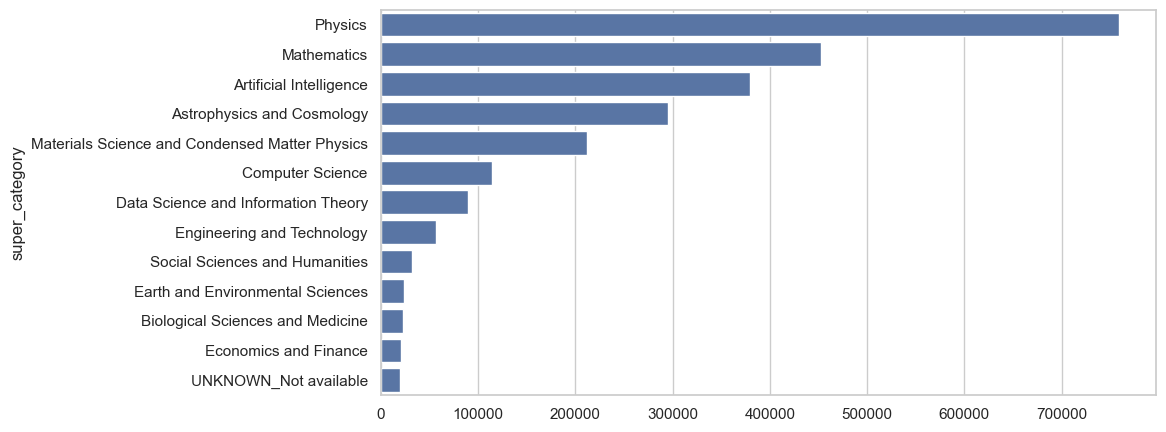

In [54]:
from matplotlib import pyplot as plt


def print_category_counts(data_df):
    category_counts = data_df['super_category'].value_counts().sort_values(ascending=False)
    for i, (cat, count) in enumerate(category_counts.items(), 1):
        print(f"[{i}] {cat}: {count}")
    print(f"Total categories: {len(category_counts)}")

def plot_category_counts(data_df, fig_size=(10, 5)):
    category_counts = data_df['super_category'].value_counts().sort_values(ascending=False)
    fig = plt.figure(figsize=fig_size)
    sns.set(style="whitegrid")
    sns.set_color_codes("pastel")
    sns.set_context("notebook")
    sns.barplot(y=category_counts.index, x=category_counts.values)

print_category_counts(data_df)
plot_category_counts(data_df)

In [62]:
# Remove papers with UNKNOWN_Not available category
data_clean_df = data_df[data_df['super_category'] != 'UNKNOWN_Not available'].reset_index(drop=True)

min_words_title = data_clean_df['title_words'].min()
min_words_abstract = data_clean_df['abstract_words'].min()
max_words_title = data_clean_df['title_words'].max()
max_words_abstract = data_clean_df['abstract_words'].max()
print(f"Min words in title: {min_words_title}")
print(f"Min words in abstract: {min_words_abstract}")
print(f"Max words in title: {max_words_title}")
print(f"Max words in abstract: {max_words_abstract}")

# show examples of papers with very few words in the title
display(data_clean_df[data_clean_df['title_words'] == min_words_title].head(3))
display(data_clean_df[data_clean_df['abstract_words'] == min_words_abstract].head(3))

# For now we will remove papers with less than 25p quantile of words in abstract and title and more than 75p quantile
title_quantiles = data_clean_df['title_words'].quantile(0.05), data_clean_df['title_words'].quantile(0.9)
abstract_quantiles = data_clean_df['abstract_words'].quantile(0.05), data_clean_df['abstract_words'].quantile(0.8)
print(f"Title quantiles: {title_quantiles}")
print(f"Abstract quantiles: {abstract_quantiles}")

# remove papers with less than 25p quantile of words in abstract and title and more than 75p quantile
data_clean_simple_df = data_clean_df[
    (data_clean_df['title_words'] >= title_quantiles[0]) & (data_clean_df['title_words'] <= title_quantiles[1]) &
    (data_clean_df['abstract_words'] >= abstract_quantiles[0]) & (data_clean_df['abstract_words'] <= abstract_quantiles[1])
].reset_index(drop=True)
print(f"Papers before cleaning: {len(data_clean_df)}")
print(f"Papers after cleaning: {len(data_clean_simple_df)}")

Min words in title: 1
Min words in abstract: 1
Max words in title: 61
Max words in abstract: 925


,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year,super_categories,amount_super_categories,super_categories_str,super_category
1378,704.1379,U-max-Statistics,"In 1948, W. Hoeffding introduced a large cla...","[math.ST, math.PR, stat.TH]",2007-05-23,1,97,"[Statistics Theory, Probability, Statistics Th...",3,2007,"[Mathematics, Mathematics, Mathematics]",3,Mathematics,Mathematics
6895,705.2893,K-Bounce,By demanding that a bounce is nonsingular an...,"[astro-ph, gr-qc, hep-th]",2008-11-26,1,90,"[Astrophysics, General Relativity and Quantum ...",3,2008,"[Astrophysics and Cosmology, Physics, Physics]",3,Astrophysics and Cosmology Physics,Physics
11607,706.2921,Herwig++,We describe the recent development of the He...,[hep-ph],2007-06-21,1,10,[High Energy Physics - Phenomenology],1,2007,[Physics],1,Physics,Physics


,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year,super_categories,amount_super_categories,super_categories_str,super_category
766954,1609.01476,Can decay be ascribed to classical noise?,No.\n,"[quant-ph, math-ph, math.MP]",2017-05-10,7,1,"[Quantum Physics, Mathematical Physics, Mathem...",3,2017,"[Physics, Physics, Physics]",3,Physics,Physics
1008542,1807.11336,Are theoretical results 'Results'?,Yes.\n,"[q-bio.OT, cond-mat.soft, physics.bio-ph]",2018-07-31,4,1,"[Other Quantitative Biology, Soft Condensed Ma...",3,2018,"[Biological Sciences and Medicine, Materials S...",3,Materials Science and Condensed Matter Physics...,Materials Science and Condensed Matter Physics
1083406,1902.02322,Is AmI (Attacks Meet Interpretability) Robust ...,No.\n,"[cs.LG, cs.AI, cs.CR, stat.ML]",2019-02-07,9,1,"[Machine Learning, Artificial Intelligence, Cr...",4,2019,"[Artificial Intelligence, Artificial Intellige...",4,Computer Science and Artificial Intelligence,Artificial Intelligence


Title quantiles: (5.0, 15.0)
Abstract quantiles: (45.0, 198.0)
Papers before cleaning: 2458215
Papers after cleaning: 1663722


[1] Physics: 565092
[2] Mathematics: 322884
[3] Artificial Intelligence: 255913
[4] Materials Science and Condensed Matter Physics: 159900
[5] Astrophysics and Cosmology: 132909
[6] Computer Science: 72022
[7] Data Science and Information Theory: 58179
[8] Engineering and Technology: 40571
[9] Social Sciences and Humanities: 19578
[10] Economics and Finance: 14522
[11] Biological Sciences and Medicine: 12649
[12] Earth and Environmental Sciences: 9503
Total categories: 12


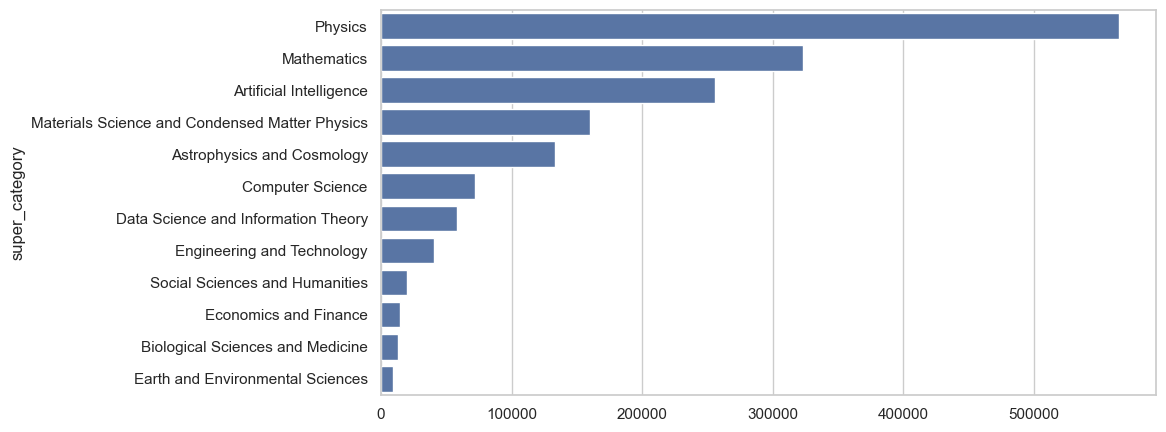

In [63]:
print_category_counts(data_clean_simple_df)
plot_category_counts(data_clean_simple_df)

In [68]:
# if a category has more than 10000 samples, we will only keep 10000 samples
sample_per_category = 10000

sampled_data_df = (
    data_clean_simple_df.groupby("super_category")
    .apply(lambda x: x.sample(min(sample_per_category, len(x)), random_state=42))
    .reset_index(drop=True)
)

C:\Users\gabri\AppData\Local\Temp\ipykernel_57208\15680853.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(sample_per_category, len(x)), random_state=42))


In [70]:
sampled_data_df.to_parquet("../data/arxiv_metadata_sample.parquet.gzip", compression="gzip", engine="pyarrow")